In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
from collections import defaultdict
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from random import shuffle

In [2]:
def parseData(fname):
    for l in open(fname):
        yield ast.literal_eval(l)

In [3]:
userData=list(parseData("yelp_dataset/yelp_academic_dataset_user.json"))

In [4]:
tipData=list(parseData("yelp_dataset/yelp_academic_dataset_tip.json"))

In [5]:
reviewData=list(parseData("yelp_dataset/yelp_academic_dataset_review.json"))

In [22]:
# Not being used
eliteData = []
noneliteData = []
for u in userData:
    if not 'None' in u['elite']:
        eliteData.append(u)
    else:
        noneliteData.append(u)

In [69]:
eliteIDs = []
for u in userData:
    if not 'None' in u['elite']:
        eliteIDs.append(u["user_id"])

In [223]:
# Not being used
eliteNumReviews = []
for e in eliteData:
    eliteNumReviews.append(e["review_count"])
avgNumReviews = np.mean(eliteNumReviews)
avgNumReviews

224.69235124945985

In [17]:
# BASELINE: Predicting not-elite for every user
predictions = [0 for u in userData]
correct = (predictions == df["elite"])
print(sum(correct) / len(correct))

0.9557960938472594


In [18]:
# BASELINE #2: Usin closeness to elite vs non-elite averages
eReviews = []
nReviews = []
eFriends = []
nFriends = []
eCompliments = []
nCompliments = []
eVotes = []
nVotes = []
for i, row in df.iterrows():
    if row["elite"] == 0:
        nReviews.append(row["numReviews"])
        nFriends.append(row["numFriends"])
        nCompliments.append(row["numCompliments"])
        nVotes.append(row["numVotes"])
    else:
        eReviews.append(row["numReviews"])
        eFriends.append(row["numFriends"])
        eCompliments.append(row["numCompliments"])
        eVotes.append(row["numVotes"])
eReviewsAvg = np.mean(eReviews)
nReviewsAvg = np.mean(nReviews)
eFriendsAvg = np.mean(eFriends)
nFriendsAvg = np.mean(nFriends)
eComplimentsAvg = np.mean(eCompliments)
nComplimentsAvg = np.mean(nCompliments)
eVotesAvg = np.mean(eVotes)
nVotesAvg = np.mean(nVotes)

In [19]:
def findCloserAvg(user_avg, elite_avg, non_elite_avg):
    mid = (elite_avg + non_elite_avg) / 2
    if user_avg >= mid:
        return 1
    else:
        return 0

In [20]:
points = []
for i,row in df.iterrows():
    point = 0
    if findCloserAvg(row["numReviews"], eReviewsAvg, nReviewsAvg):
        point += 1
    if findCloserAvg(row["numFriends"], eFriendsAvg, nFriendsAvg):
        point += 1
    if findCloserAvg(row["numCompliments"], eComplimentsAvg, nComplimentsAvg):
        point += 1
    if findCloserAvg(row["numVotes"], eVotesAvg, nVotesAvg):
        point += 1
    points.append(point)

In [21]:
pre = []
for p in points:
    if p == 4:
        pre.append(1)
    else:
        pre.append(0)
print(mean_squared_error(df["elite"], pre))
print(accuracy_score(df["elite"], pre))

0.04003506855956089
0.9599649314404392


## Using Only the User Data

In [96]:
def apr(yhat, true, threshold):
    predictions = (yhat > threshold)
    correct = (predictions == true)
    truepos, trueneg, falsepos, falseneg = 0,0,0,0
    for (a,b) in zip(predictions, true):
        if a==True and b==True:
            truepos+=1
        elif a==False and b==False:
            trueneg+=1
        elif a==True and b==False:
            falsepos+=1
        else:
            falseneg+=1
    acc = sum(correct) / len(correct)
    precision = truepos / (truepos + falsepos)
    recall = truepos / (truepos + falseneg)
    return acc, precision, recall

In [7]:
def sumCompliments(user):
    compliment_count = user["compliment_hot"] + user["compliment_more"]
    + user["compliment_profile"] + user["compliment_cute"] + user["compliment_list"]
    + user["compliment_note"] + user["compliment_plain"] + user["compliment_cool"]
    + user["compliment_funny"] + user["compliment_writer"] + user["compliment_photos"]
    return compliment_count

In [8]:
def sumVotes(user):
    useful = user['useful']
    funny = user['funny']
    cool = user['cool']
    return useful + funny + cool

In [9]:
numReviews = []
numCompliments = []
numVotes = []
numAvgRatings = []
numFans = []
numFriends = []
elite = []
for u in userData:
    numReviews.append(u["review_count"])
    numCompliments.append(sumCompliments(u))
    numVotes.append(sumVotes(u))
    numAvgRatings.append(u["average_stars"])
    numFans.append(u["fans"])
    
    if 'None' in u['friends']:
        numFriends.append(0)
    else:
        numFriends.append(len(u['friends'].split(", ")))
    
    if not 'None' in u['elite']:
        elite.append(1)
    else:
        elite.append(0)

In [36]:
df = pd.DataFrame()
df['numReviews'] = numReviews
df['numFriends'] = numFriends
df['numCompliments'] = numCompliments
df['numVotes'] = numVotes
df['numFans'] = numFans
df['numAvgRatings'] = numAvgRatings
df['elite'] = elite

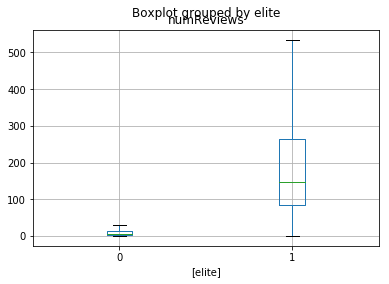

In [11]:
df.boxplot(by=["elite"], column=["numReviews"], showfliers=False)

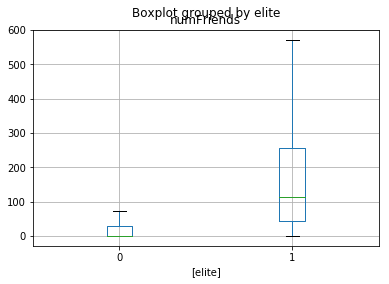

In [12]:
df.boxplot(by=["elite"], column=["numFriends"], showfliers=False)

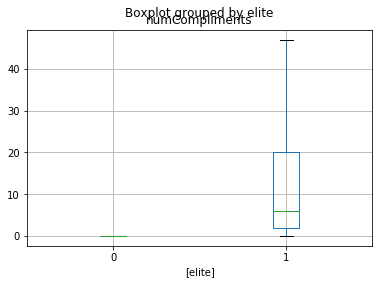

In [13]:
df.boxplot(by=["elite"], column=["numCompliments"], showfliers=False)

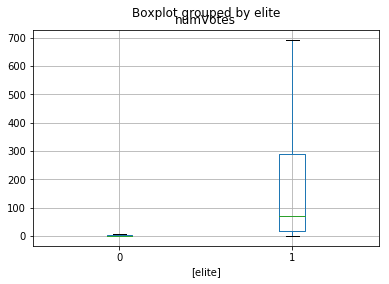

In [14]:
df.boxplot(by=["elite"], column=["numVotes"], showfliers=False)

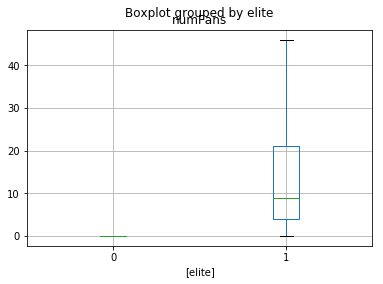

In [15]:
df.boxplot(by=["elite"], column=["numFans"], showfliers=False)

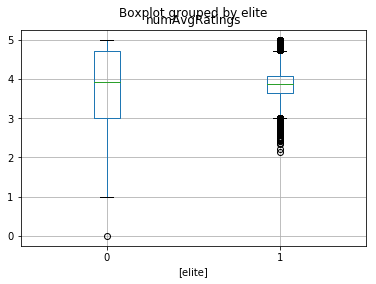

In [16]:
df.boxplot(by=["elite"], column=["numAvgRatings"])

Looks like most of these features will be able to pretty accurately predict eliteness since the boxplots between elite and non-elite are quite different. For number of average ratings the values are similar but the variance is not.

In [25]:
def log_normalization(val):
    if val > 0:
        return np.log(val)
    else:
        return np.log(val + .001)

In [37]:
df_init = df.copy()
for d in df:
    if d == 'numAvgRatings' or d == 'elite':
        continue
    df[d] = df[d].apply(log_normalization)

In [38]:
mse1=[]
for d in df:
    if d == 'elite':
        break
    formula = 'elite ~ ' + d
    model=smf.logit(formula, data=df).fit(disp=0)
    yhat1 = model.predict(df[d])
    mse1.append(mean_squared_error(df["elite"], yhat1))
    print(model.summary())
print(mse1)

                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1518169
Model:                          Logit   Df Residuals:                  1518167
Method:                           MLE   Df Model:                            1
Date:                Sun, 02 Dec 2018   Pseudo R-squ.:                  0.6377
Time:                        21:29:22   Log-Likelihood:                -99591.
converged:                       True   LL-Null:                   -2.7491e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.8682      0.035   -338.333      0.000     -11.937     -11.799
numReviews     2.4474      0.008    310.524      0.000       2.432       2.463

Possibly complete quasi-separation: A fraction 0.31

Text(0.5,1,'MSE of Each User Feature Separately')

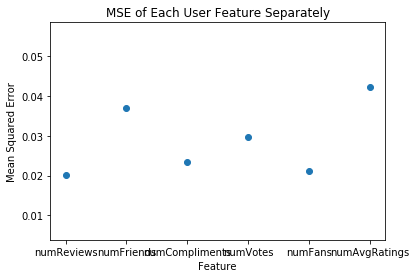

In [64]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings']
plt.scatter(features,mse1)
plt.xlabel("Feature")
plt.ylabel("Mean Squared Error")
plt.title("MSE of Each User Feature Separately")

(0.022, 0.023)

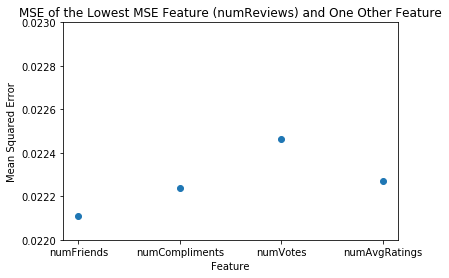

In [115]:
plt.scatter(features[1:],mse2)
plt.xlabel("Feature")
plt.ylabel("Mean Squared Error")
plt.title("MSE of the Lowest MSE Feature (numReviews) and One Other Feature")
plt.ylim((0.022, 0.023)) 

In [184]:
mse3=[]
for d in df:
    if d == 'elite' or d == 'numReviews' or d == 'numFriends':
        continue
    formula = 'elite ~ numReviews + numFriends + ' + d
    model=smf.logit(formula, data=df).fit()
    yhat3 = model.predict(df[['numReviews', 'numFriends', d]])
    mse3.append(mean_squared_error(df["elite"], yhat3))
print(mse3)

Optimization terminated successfully.
         Current function value: 0.089151
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089193
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088617
         Iterations 9
[0.02203510322082871, 0.022114650797740137, 0.0219505002452953]


(0.0218, 0.0222)

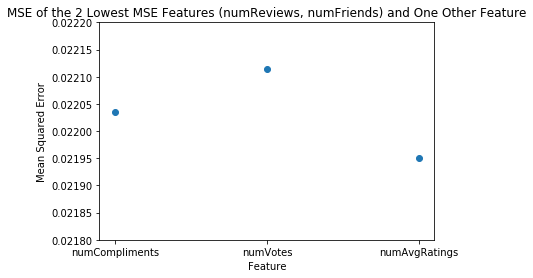

In [120]:
plt.scatter(features[2:],mse3)
plt.xlabel("Feature")
plt.ylabel("Mean Squared Error")
plt.title("MSE of the 2 Lowest MSE Features (numReviews, numFriends) and One Other Feature")
plt.ylim((0.0218, 0.0222))

In [185]:
mse4=[]
for d in df:
    if d == 'elite' or d == 'numReviews' or d == 'numFriends' or d == 'numAvgRatings':
        continue
    formula = 'elite ~ numReviews + numFriends + numAvgRatings + ' + d
    model=smf.logit(formula, data=df).fit()
    yhat4 = model.predict(df[['numReviews', 'numFriends', 'numAvgRatings', d]])
    mse4.append(mean_squared_error(df["elite"], yhat4))
print(mse4)

Optimization terminated successfully.
         Current function value: 0.088567
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088609
         Iterations 9
[0.021879337456883984, 0.02195663183623636]


(0.0218, 0.022)

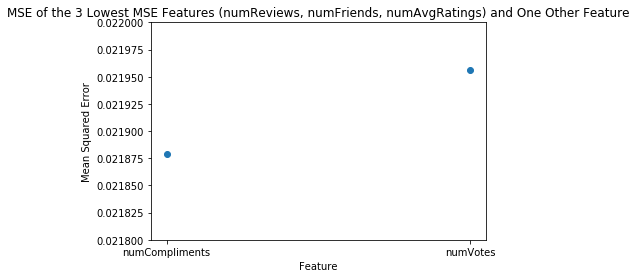

In [124]:
plt.scatter(features[2:4],mse4)
plt.xlabel("Feature")
plt.ylabel("Mean Squared Error")
plt.title("MSE of the 3 Lowest MSE Features (numReviews, numFriends, numAvgRatings) and One Other Feature")
plt.ylim((0.0218, 0.022))

In [94]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings']
formula = 'elite ~ numReviews + numFriends + numAvgRatings + numCompliments + numVotes + numFans'
model=smf.logit(formula, data=df).fit(disp=0)
yhat6 = model.predict(df[features])
mse6 = mean_squared_error(df["elite"], yhat6)
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1518169
Model:                          Logit   Df Residuals:                  1518162
Method:                           MLE   Df Model:                            6
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:                  0.6958
Time:                        00:40:43   Log-Likelihood:                -83622.
converged:                       True   LL-Null:                   -2.7491e+05
                                        LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -12.4442      0.081   -152.984      0.000     -12.604     -12.285
numReviews         1.7361      0.010    174.319      0.000       1.717       1.756
numFriends         0.1904      0.004

In [107]:
print(mse6)
print(apr(yhat6, df["elite"], 0.4))

0.01670097434236711
(0.9764031540625583, 0.7325780216185676, 0.73419362529616)


In [66]:
mse_train = []
acc_train = []
prec_train = []
rec_train = []
mse_test = []
acc_test = []
prec_test = []
rec_test = []
formula = 'elite ~ numReviews + numFriends + numAvgRatings + numCompliments + numVotes + numFans'
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index, :]
    df_test = df.iloc[test_index, :]
    mod = smf.logit(formula, data=df_train).fit(disp=0)
    yhat_train = mod.predict(df_train[features])
    mse_train.append(mean_squared_error(df_train["elite"], yhat_train))
    a,p,r = apr(yhat_train, df_train["elite"], 0.4)
    acc_train.append(a)
    prec_train.append(p)
    rec_train.append(r)
    yhat_test = mod.predict(df_test[features])
    mse_test.append(mean_squared_error(df_test["elite"], yhat_test))
    a,p,r = apr(yhat_test, df_test["elite"], 0.4)
    acc_test.append(a)
    prec_test.append(p)
    rec_test.append(r)
print("The average training error is " + str(np.mean(mse_train)))
print("The average training accuracy is " + str(np.mean(acc_train)))
print("The average training precision is " + str(np.mean(prec_train)))
print("The average training recall is " + str(np.mean(rec_train)))
print("The average testing error is " + str(np.mean(mse_test)))
print("The average testing accuracy is " + str(np.mean(acc_test)))
print("The average testing precision is " + str(np.mean(prec_test)))
print("The average testing recall is " + str(np.mean(rec_test)))

The average training error is 0.016700911998193856
The average training accuracy is 0.9764057888140559
The average training precision is 0.7326043381687206
The average training recall is 0.7342297599601728
The average testing error is 0.016702056891374537
The average testing accuracy is 0.9764038126825442
The average testing precision is 0.7325737645162982
The average testing recall is 0.7341920466530254


I wanted to see if the features used would be redundant at some point, and used a forward stepwise selection to choose the best features one by one. However in this case, the model with the lowest MSE and best accuracy still ended up being the one using all the features, which I guess makes sense and is okay since we only have 5 features total here. I used K-fold cross validation to check that the testing error and accuracy wouldn't be wildly different from training, which is wasn't. I chose 0.3 for the accuracy threshold since that seemed to produce the best results.

## Some Extra Friend Data

In [75]:
eliteIDs = set(eliteIDs)

In [100]:
sumEliteFriends = []
ratioEliteFriends = []
for u in userData:
    if not 'None' in u['friends']:
        friends = u['friends'].split(", ")
        sumE = 0
        for f in friends:
            if f in eliteIDs:
                sumE += 1
        sumEliteFriends.append(sumE)
        ratioEliteFriends.append(sumE * 1.0/len(friends))
    else:
        sumEliteFriends.append(0)
        ratioEliteFriends.append(0)

In [82]:
df["sumEliteFriends"] = sumEliteFriends
df["ratioEliteFriends"] = ratioEliteFriends
df["sumEliteFriends"]=df["sumEliteFriends"].apply(log_normalization)
0.015613203969927566
(0.9779662211519271, 0.7463549595971425, 0.7597341638230342)

In [117]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings', 'sumEliteFriends', 'ratioEliteFriends']
formula = 'elite ~ numReviews + numFriends + numAvgRatings + numCompliments + numVotes + numFans + sumEliteFriends + ratioEliteFriends'
mse_train = []
acc_train = []
prec_train = []
rec_train = []
mse_test = []
acc_test = []
prec_test = []
rec_test = []
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index, :]
    df_test = df.iloc[test_index, :]
    mod = smf.logit(formula, data=df_train).fit(disp=0)
    yhat_train = mod.predict(df_train[features])
    mse_train.append(mean_squared_error(df_train["elite"], yhat_train))
    a,p,r = apr(yhat_train, df_train["elite"], 0.4)
    acc_train.append(a)
    prec_train.append(p)
    rec_train.append(r)
    yhat_test = mod.predict(df_test[features])
    mse_test.append(mean_squared_error(df_test["elite"], yhat_test))
    a,p,r = apr(yhat_test, df_test["elite"], 0.4)
    acc_test.append(a)
    prec_test.append(p)
    rec_test.append(r)
print("The average training error is " + str(np.mean(mse_train)))
print("The average training accuracy is " + str(np.mean(acc_train)))
print("The average training precision is " + str(np.mean(prec_train)))
print("The average training recall is " + str(np.mean(rec_train)))
print("The average testing error is " + str(np.mean(mse_test)))
print("The average testing accuracy is " + str(np.mean(acc_test)))
print("The average testing precision is " + str(np.mean(prec_test)))
print("The average testing recall is " + str(np.mean(rec_test)))

The average training error is 0.01566917845958966
The average training accuracy is 0.9778225539373182
The average training precision is 0.7436166800329566
The average training recall is 0.7604935522684528
The average testing error is 0.015671053157686708
The average testing accuracy is 0.977812087942571
The average testing precision is 0.74348751289832
The average testing recall is 0.7604031008392563


In [118]:
print(mod.summary())

                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1366353
Model:                          Logit   Df Residuals:                  1366345
Method:                           MLE   Df Model:                            7
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:                  0.7144
Time:                        01:15:29   Log-Likelihood:                -70740.
converged:                       True   LL-Null:                   -2.4767e+05
                                        LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.3152      0.089   -127.375      0.000     -11.489     -11.141
numReviews          1.6395      0.011    153.250      0.000       1.619       1.660
numFriends         -0.0645      

## Using Tip Data

In [67]:
tipCounts = defaultdict(int)
tipLikes = defaultdict(int)
for t in tipData:
    tipCounts[t["user_id"]] += 1
    tipLikes[t["user_id"]] += t["likes"]

In [121]:
numTips = []
numTipLikes = []
numTipRatio = []
for u in userData:
    if u["user_id"] in tipCounts:
        numTips.append(tipCounts[u["user_id"]])
        numTipLikes.append(tipLikes[u["user_id"]])
        if tipLikes[u["user_id"]] > 0:
            numTipRatio.append(tipLikes[u["user_id"]]/(tipCounts[u["user_id"]]*1.0))
        else:
            numTipRatio.append(0)
    else:
        numTips.append(0)
        numTipLikes.append(0)
        numTipRatio.append(0)

In [122]:
df['numTips'] = numTips
df['numTipLikes'] = numTipLikes
df['numTipRatio'] = numTipRatio

In [128]:
df['numTips'] = df['numTips'].apply(log_normalization)
df['numTipLikes'] = df['numTipLikes'].apply(log_normalization)

In [130]:
mse1_tip = []
acc1_tip = []
for d in df:
    if d == "numTips" or d == "numTipLikes" or d == "numTipRatio":
        formula = 'elite ~ ' + d
        model=smf.logit(formula, data=df).fit(disp=0)
        yhat1_tip = model.predict(df[d])
        #mse1_tip.append(mean_squared_error(df_tip["elite"], yhat1_tip))
        #acc1_tip.append(accuracy(yhat1_tip, df_tip["elite"], 0.3))
        print(model.summary())
#print(mse1_tip)
#print(acc1_tip)

                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1518169
Model:                          Logit   Df Residuals:                  1518167
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:                 0.02428
Time:                        01:28:47   Log-Likelihood:            -2.6824e+05
converged:                       True   LL-Null:                   -2.7491e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4533      0.006   -416.491      0.000      -2.465      -2.442
numTips        0.1299      0.001    121.523      0.000       0.128       0.132
                           Logit Regression Results 

In [136]:
formula = 'elite ~ numTips + numTipLikes + numTipRatio'
model=smf.logit(formula, data=df).fit(disp=0)
yhat_tip = model.predict(df[['numTips', 'numTipLikes', 'numTipRatio']])
mse_tip = mean_squared_error(df["elite"], yhat_tip)
print(mse_tip)
print(model.summary())

0.04133254729991649
                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1518169
Model:                          Logit   Df Residuals:                  1518165
Method:                           MLE   Df Model:                            3
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:                 0.03117
Time:                        01:38:05   Log-Likelihood:            -2.6634e+05
converged:                       True   LL-Null:                   -2.7491e+05
                                        LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.7727      0.028    -27.779      0.000      -0.827      -0.718
numTips         0.1120      0.001     99.158      0.000       0.110       0.114
numTipLikes     0.2590      

The tip data gives us a slight edge over baseline, but not by much. The feature set with the highest accuracy was numTipLikes. We'll test this out on top of the user features.

In [411]:
df_wtip = df[['numReviews','numFriends','numCompliments','numVotes','numAvgRatings','elite']]
df_wtip['numTipLikes'] = numTipLikes

In [370]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numAvgRatings', 'numTipLikes']

In [137]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings', 'sumEliteFriends', 'ratioEliteFriends', 'numTips']
formula = 'elite ~ numReviews + numFriends + numAvgRatings + numCompliments + numVotes + numFans + sumEliteFriends + ratioEliteFriends + numTips'
mse_train = []
acc_train = []
prec_train = []
rec_train = []
mse_test = []
acc_test = []
prec_test = []
rec_test = []
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index, :]
    df_test = df.iloc[test_index, :]
    mod = smf.logit(formula, data=df_train).fit(disp=0)
    yhat_train = mod.predict(df_train[features])
    mse_train.append(mean_squared_error(df_train["elite"], yhat_train))
    a,p,r = apr(yhat_train, df_train["elite"], 0.4)
    acc_train.append(a)
    prec_train.append(p)
    rec_train.append(r)
    yhat_test = mod.predict(df_test[features])
    mse_test.append(mean_squared_error(df_test["elite"], yhat_test))
    a,p,r = apr(yhat_test, df_test["elite"], 0.4)
    acc_test.append(a)
    prec_test.append(p)
    rec_test.append(r)
print("The average training error is " + str(np.mean(mse_train)))
print("The average training accuracy is " + str(np.mean(acc_train)))
print("The average training precision is " + str(np.mean(prec_train)))
print("The average training recall is " + str(np.mean(rec_train)))
print("The average testing error is " + str(np.mean(mse_test)))
print("The average testing accuracy is " + str(np.mean(acc_test)))
print("The average testing precision is " + str(np.mean(prec_test)))
print("The average testing recall is " + str(np.mean(rec_test)))

The average training error is 0.01560216479531778
The average training accuracy is 0.97795758501578
The average training precision is 0.7462428639081289
The average training recall is 0.7596696618598474
The average testing error is 0.015604044681236657
The average testing accuracy is 0.9779556819268042
The average testing precision is 0.7462671044800802
The average testing recall is 0.7595973037049223


In [ ]:
The average training error is 0.015613125660818766
The average training accuracy is 0.9779664407198752
The average training precision is 0.7463867836734787
The average training recall is 0.759676340163405
The average testing error is 0.01561444227434231
The average testing accuracy is 0.9779635867222914
The average testing precision is 0.7463717417074281
The average testing recall is 0.7596678473660
0.7152

In [138]:
print(mod.summary())

                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1366353
Model:                          Logit   Df Residuals:                  1366343
Method:                           MLE   Df Model:                            9
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:                  0.7160
Time:                        01:40:40   Log-Likelihood:                -70331.
converged:                       True   LL-Null:                   -2.4761e+05
                                        LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -12.0345      0.093   -129.663      0.000     -12.216     -11.853
numReviews            1.6511      0.011    153.454      0.000       1.630       1.672
numFriends            0.

## Using Rating Data

In [139]:
reviewLengths = defaultdict(list)
reviewUsefuls = defaultdict(int)
reviewFunnys = defaultdict(int)
reviewCools = defaultdict(int)
reviewParagraphs = defaultdict(int)
reviewBullets = defaultdict(int)
reviewProCon = defaultdict(int)
reviewColons = defaultdict(int)
for r in reviewData:
    reviewLengths[r["user_id"]].append(len(r["text"]))
    reviewUsefuls[r["user_id"]] += r["useful"]
    reviewFunnys[r["user_id"]] += r["funny"]
    reviewCools[r["user_id"]] += r["cool"]
    
    if "\n" in r["text"]:
        reviewParagraphs[r["user_id"]] += 1
    if "-" in r["text"] or "1." in r["text"] or "1)" in r["text"]:
        reviewBullets[r["user_id"]] += 1
    if "Pros" in r["text"] or "Cons" in r["text"] or "PROS" in r["text"] or "CONS" in r["text"] or "Pro" in r["text"] or "Con" in r["text"]:
        reviewProCon[r["user_id"]] += 1
    if ":" in r["text"]:
        reviewColons[r["user_id"]] += 1

In [140]:
avgLength = []
numUsefuls = []
numFunnys = []
numCools = []
numParagraphs = []
numBullets = []
numProCon = []
numColons = []
for u in userData:
    if u["user_id"] in reviewLengths:
        avgLength.append(sum(reviewLengths[u["user_id"]])/len(reviewLengths[u["user_id"]]))
        numUsefuls.append(reviewUsefuls[u["user_id"]])
        numFunnys.append(reviewFunnys[u["user_id"]])
        numCools.append(reviewCools[u["user_id"]])

        if reviewParagraphs[u["user_id"]]:
            numParagraphs.append(reviewParagraphs[u["user_id"]])
        else:
            numParagraphs.append(0)
            
        if reviewBullets[u["user_id"]]:
            numBullets.append(reviewBullets[u["user_id"]])
        else:
            numBullets.append(0)
            
        if reviewProCon[u["user_id"]]:
            numProCon.append(reviewProCon[u["user_id"]])
        else:
            numProCon.append(0)
            
        if reviewColons[u["user_id"]]:
            numColons.append(reviewColons[u["user_id"]])
        else:
            numColons.append(0)
    else:
        avgLength.append(0)
        numUsefuls.append(0)
        numFunnys.append(0)
        numCools.append(0)
        numParagraphs.append(0)
        numBullets.append(0)
        numProCon.append(0)
        numColons.append(0)

In [141]:
df['avgLength'] = avgLength
df['numUsefuls'] = numUsefuls
df['numFunnys'] = numFunnys
df['numCools'] = numCools
df['numParagraphs'] = numParagraphs
df['numBullets'] = numBullets
df['numProCon'] = numProCon
df['numColons'] = numColons

In [144]:
df['avgLength'] = df['avgLength'].apply(log_normalization)
df['numUsefuls'] = df['numUsefuls'].apply(log_normalization)
df['numFunnys'] = df['numFunnys'].apply(log_normalization)
df['numCools'] = df['numCools'].apply(log_normalization)
df['numParagraphs'] = df['numParagraphs'].apply(log_normalization)
df['numBullets'] = df['numBullets'].apply(log_normalization)
df['numProCon'] = df['numProCon'].apply(log_normalization)
df['numColons'] = df['numColons'].apply(log_normalization)

In [145]:
newfeat = ['avgLength', 'numUsefuls', 'numFunnys', 'numCools', 'numParagraphs', 'numBullets', 'numProCon', 'numColons']
for d in df:
    if d in newfeat:
        formula = 'elite ~ ' + d
        model=smf.logit(formula, data=df).fit(disp=0)
        yhat1_rev = model.predict(df[d])
        print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1518169
Model:                          Logit   Df Residuals:                  1518167
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:                 0.06551
Time:                        02:06:36   Log-Likelihood:            -2.5690e+05
converged:                       True   LL-Null:                   -2.7491e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.3677      0.035   -265.553      0.000      -9.437      -9.299
avgLength      1.0110      0.005    186.565      0.000       1.000       1.022
                           Logit Regression Results 

                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1518169
Model:                          Logit   Df Residuals:                  1518167
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:                 0.09875
Time:                        02:07:06   Log-Likelihood:            -2.4776e+05
converged:                       True   LL-Null:                   -2.7491e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9916      0.005   -394.653      0.000      -2.002      -1.982
numColons      0.2565      0.001    236.656      0.000       0.254       0.259


In [148]:
formula = 'elite ~ avgLength + numUsefuls + numFunnys + numCools + numParagraphs + numBullets + numProCon + numColons'
model=smf.logit(formula, data=df).fit(disp=0)
yhat_rev = model.predict(df[['avgLength','numUsefuls','numFunnys','numCools','numParagraphs','numBullets','numProCon','numColons']])
mse_rev = mean_squared_error(df["elite"], yhat_rev)
print(mse_rev)
a,p,r = (apr(yhat_rev, df["elite"], 0.3))
print(a)
print(p)
print(r)

0.03454031416831849
0.9564514886023888
0.5139861122824773
0.27243737799698997


In [149]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1518169
Model:                          Logit   Df Residuals:                  1518160
Method:                           MLE   Df Model:                            8
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:                  0.2466
Time:                        02:14:08   Log-Likelihood:            -2.0712e+05
converged:                       True   LL-Null:                   -2.7491e+05
                                        LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.5081      0.047    -95.054      0.000      -4.601      -4.415
avgLength         0.4477      0.007     62.711      0.000       0.434       0.462
numUsefuls       -0.0102      0.002     

In [400]:
mse2_rev=[]
acc2_rev=[]
for d in df_rev:
    if d == 'elite' or d == 'numCools':
        continue
    formula = 'elite ~ numCools + ' + d
    model=smf.logit(formula, data=df_rev).fit(disp=0)
    yhat2_rev = model.predict(df_rev[['numCools', d]])
    mse2_rev.append(mean_squared_error(df_rev["elite"], yhat2_rev))
    acc2_rev.append(accuracy(yhat2_rev, df_rev["elite"], 0.3))
print(mse2_rev)
print(acc2_rev)

[0.036549038522721025, 0.03674813858553456, 0.036675126574780594, 0.03634376459379504, 0.036440244743754575, 0.03659941665859149, 0.03651233405477382]
[0.9589426473600765, 0.9598371459303938, 0.9599550511174975, 0.959730438442624, 0.9596803781397196, 0.9599273862132608, 0.9597818161219206]


In [410]:
mse3_rev=[]
acc3_rev=[]
for d in df_rev:
    if d == 'elite' or d == 'numCools' or d == 'numFunnys':
        continue
    formula = 'elite ~ numCools + numFunnys + ' + d
    model=smf.logit(formula, data=df_rev).fit(disp=0)
    yhat3_rev = model.predict(df_rev[['numCools', 'numFunnys', d]])
    mse3_rev.append(mean_squared_error(df_rev["elite"], yhat3_rev))
    acc3_rev.append(accuracy(yhat2_rev, df_rev["elite"], 0.3))
print(mse3_rev)
print(acc3_rev)

[0.036513152111218326, 0.0367330245867535, 0.03628490736242809, 0.03639270720529811, 0.036562030474991035, 0.036462790264217323, 0.0367330245867531]
[0.9597818161219206, 0.9597818161219206, 0.9597818161219206, 0.9597818161219206, 0.9597818161219206, 0.9597818161219206, 0.9597818161219206]


In [396]:
## Using all features:
## 0.03576745709167296
## 0.9593661838701751

## Using only the vote (Useful/Funny/Cool) features:
## 0.036733024586753496
## 0.9598404393713743

## Using only the review text (Paragraphs/Bullets/ProCon/Colons) features:
## 0.037157969461905554
## 0.9586475550482193

In [403]:
numTotalVotes = []
for a,b,c in zip(numUsefuls, numFunnys, numCools):
    numTotalVotes.append(a+b+c)
df_rev['numTotalVotes'] = numTotalVotes

In [405]:
formula = 'elite ~ + numTotalVotes'
model=smf.logit(formula, data=df_rev).fit(disp=0)
yhatT_rev = model.predict(df_rev['numTotalVotes'])
print(mean_squared_error(df_rev["elite"], yhatT_rev))
print(accuracy(yhatT_rev, df_rev["elite"], 0.3))
print(model.summary())

0.03739656752838877
0.9590816305694557
                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1518169
Model:                          Logit   Df Residuals:                  1518167
Method:                           MLE   Df Model:                            1
Date:                Sun, 02 Dec 2018   Pseudo R-squ.:                  0.1083
Time:                        14:00:07   Log-Likelihood:            -2.4513e+05
converged:                       True   LL-Null:                   -2.7491e+05
                                        LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.3584      0.005   -745.472      0.000      -3.367      -3.350
numTotalVotes     0.0203      0.000    173.083      0.000       0.020       0.021


It looks like the best feature set out of the reviews to use is using Number of Cool Votes and Number of Funny Votes. We'll add this to our user and tip features to see if we can get the accuracy better.

In [414]:
df_tu = df_wtip.copy()
df_tu['numFunnys'] = numFunnys
df_tu['numCools'] = numCools

In [157]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings', 'sumEliteFriends', 'numTipLikes','avgLength','numUsefuls','numFunnys','numCools','numParagraphs','numBullets']
formula = 'elite ~ numReviews + numFriends + numCompliments + numVotes + numFans + numAvgRatings + sumEliteFriends + numTipLikes + avgLength + numUsefuls + numFunnys + numCools + numParagraphs + numBullets'
mse_train = []
acc_train = []
prec_train = []
rec_train = []
mse_test = []
acc_test = []
prec_test = []
rec_test = []
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index, :]
    df_test = df.iloc[test_index, :]
    mod = smf.logit(formula, data=df_train).fit(disp=0)
    yhat_train = mod.predict(df_train[features])
    mse_train.append(mean_squared_error(df_train["elite"], yhat_train))
    a,p,r = apr(yhat_train, df_train["elite"], 0.4)
    acc_train.append(a)
    prec_train.append(p)
    rec_train.append(r)
    yhat_test = mod.predict(df_test[features])
    mse_test.append(mean_squared_error(df_test["elite"], yhat_test))
    a,p,r = apr(yhat_test, df_test["elite"], 0.4)
    acc_test.append(a)
    prec_test.append(p)
    rec_test.append(r)
print("The average training error is " + str(np.mean(mse_train)))
print("The average training accuracy is " + str(np.mean(acc_train)))
print("The average training precision is " + str(np.mean(prec_train)))
print("The average training recall is " + str(np.mean(rec_train)))
print("The average testing error is " + str(np.mean(mse_test)))
print("The average testing accuracy is " + str(np.mean(acc_test)))
print("The average testing precision is " + str(np.mean(prec_test)))
print("The average testing recall is " + str(np.mean(rec_test)))

The average training error is 0.015490379675519273
The average training accuracy is 0.978123281688662
The average training precision is 0.7472822263649178
The average training recall is 0.7631944375744925
The average testing error is 0.01549320709622122
The average testing accuracy is 0.9781177190772666
The average testing precision is 0.7472175386501758
The average testing recall is 0.7631636166728334


In [153]:
print(mod.summary())

                           Logit Regression Results                           
Dep. Variable:                  elite   No. Observations:              1366353
Model:                          Logit   Df Residuals:                  1366336
Method:                           MLE   Df Model:                           16
Date:                Mon, 03 Dec 2018   Pseudo R-squ.:                  0.7210
Time:                        02:37:21   Log-Likelihood:                -69103.
converged:                       True   LL-Null:                   -2.4764e+05
                                        LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -15.2575      0.138   -110.707      0.000     -15.528     -14.987
numReviews          1.6775      0.011    152.620      0.000       1.656       1.699
numFriends         -0.0492      

In [ ]:
The average training error is 0.015283827412461209
The average training accuracy is 0.9783484798644595
The average training precision is 0.7496156383852501
The average training recall is 0.766070376382804
The average testing error is 0.015287361803250302
The average testing accuracy is 0.9783416731377033
The average testing precision is 0.7495898051876216
The average testing recall is 0.765922260305462

The average training error is 0.01549034353337977
The average training accuracy is 0.9781206469434514
The average training precision is 0.7472498727067626
The average training recall is 0.7631713984257731
The average testing error is 0.015493755284432795
The average testing accuracy is 0.9781157435736756
The average testing precision is 0.747130809781954
The average testing recall is 0.7633080148435205

The average training error is 0.015490379675519273
The average training accuracy is 0.978123281688662
The average training precision is 0.7472822263649178
The average training recall is 0.7631944375744925
The average testing error is 0.01549320709622122
The average testing accuracy is 0.9781177190772666
The average testing precision is 0.7472175386501758
The average testing recall is 0.7631636166728334

So our highest accuracy using Logistic Regression was using 8 features: number of reviews, number of friends, average rating, number of compliments, number of votes given, number of tip likes, number of funny votes received, and number of cool votes received. This puts us $0.9733119304045346-0.9557960938472594 = 0.01751583655$ above baseline which accounts for around 40% of the missed accuracy so far.

## Using SVM Instead of Logistic Regression

In [158]:
features = ['numReviews', 'numFriends', 'numCompliments', 'numVotes', 'numFans', 'numAvgRatings', 'sumEliteFriends', 'numTipLikes','avgLength','numUsefuls','numFunnys','numCools','numParagraphs','numBullets']

In [159]:
def feature(d):
    feat = []
    for f in features:
        feat.append(d[f])
    return feat

In [165]:
selected_df = df[features].copy()
selected_df["elite"] = df["elite"]

In [166]:
shuffled_df = selected_df.sample(frac=1)

In [167]:
X = [feature(row) for i,row in shuffled_df.iterrows()]
y = [row['elite'] for i,row in shuffled_df.iterrows()]

In [168]:
X_train = X[:len(shuffled_df)//2]
y_train = y[:len(shuffled_df)//2]
X_test = X[len(shuffled_df)//2:]
y_test = y[len(shuffled_df)//2:]

In [ ]:
clf = svm.SVC(C=1.0, kernel='sigmoid')
clf.fit(X_train, y_train)

In [ ]:
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
correct_train = (train_predictions == y_train)
correct_test = (test_predictions == y_test)
trainAcc = sum(correct_train) / len(correct_train)
print("Training accuracy was " + str(trainAcc))
testAcc = sum(correct_test) / len(correct_test)
print("Test accuracy was " + str(testAcc))